# Lab 3: Bayes Classifier and Boosting

## Jupyter notebooks

In this lab, you can use Jupyter <https://jupyter.org/> to get a nice layout of your code and plots in one document. However, you may also use Python as usual, without Jupyter.

If you have Python and pip, you can install Jupyter with `sudo pip install jupyter`. Otherwise you can follow the instruction on <http://jupyter.readthedocs.org/en/latest/install.html>.

And that is everything you need! Now use a terminal to go into the folder with the provided lab files. Then run `jupyter notebook` to start a session in that folder. Click `lab3.ipynb` in the browser window that appeared to start this very notebook. You should click on the cells in order and either press `ctrl+enter` or `run cell` in the toolbar above to evaluate all the expressions.

Be sure to put `%matplotlib inline` at the top of every code cell where you call plotting functions to get the resulting plots inside the document.

## Import the libraries

In Jupyter, select the cell below and press `ctrl + enter` to import the needed libraries.
Check out `labfuns.py` if you are interested in the details.

In [2]:
import numpy as np
from scipy import misc
from imp import reload
from labfuns import *
import random

## Bayes classifier functions to implement

The lab descriptions state what each function should do.

In [3]:
# NOTE: you do not need to handle the W argument for this part!
# in: labels - N vector of class labels
# out: prior - C x 1 vector of class priors
def computePrior(labels, W=None):
    Npts = labels.shape[0]
    if W is None:
        W = np.ones((Npts,1))/Npts
    else:
        assert(W.shape[0] == Npts)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    prior = np.zeros((Nclasses,1))

    classes = np.unique(labels)

    for i in range(len(classes)):
        count = (labels == i).sum()
        prior[i] = float(count)/len(labels)        

    return prior

# NOTE: you do not need to handle the W argument for this part!
# in:      X - N x d matrix of N data points
#     labels - N vector of class labels
# out:    mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
def mlParams(X, labels, W=None):
    assert(X.shape[0]==labels.shape[0])
    Npts,Ndims = np.shape(X)
    classes = np.unique(labels)
    Nclasses = np.size(classes)

    if W is None:
        W = np.ones((Npts,1))/float(Npts)

    mu = np.zeros((Nclasses,Ndims))
    sigma = np.zeros((Nclasses,Ndims,Ndims))
    
    classes = np.unique(labels) # Get the unique examples
    # Iterate over both index and value
    for idx,clazz in enumerate(classes):
        ix = idx
        idx = labels==clazz # Returns a true or false with the length of y
        # Or more compactly extract the indices for which y==class is true,
        # analogous to MATLAB’s find
        idx = np.where(labels==clazz)[0]
        xlc = X[idx,:] # Get the x for the class labels. Vectors are rows.
        index = 0
        for column in xlc.T:
            mean = np.mean(column)
            mu[clazz,index] = mean
            index += 1

    for k in range(len(classes)):
        n_sum = 0
        for ni in range(len(labels)):
            if labels[ni] == k:
                n_sum += 1
                subtracted = X[ni] - mu[k]
                sigma[k,:,:] += subtracted.reshape(-1,1)*subtracted
        sigma[k,:,:] /= n_sum

    return mu, sigma

# in:      X - N x d matrix of M data points
#      prior - C x 1 matrix of class priors
#         mu - C x d matrix of class means (mu[i] - class i mean)
#      sigma - C x d x d matrix of class covariances (sigma[i] - class i sigma)
# out:     h - N vector of class predictions for test points
def classifyBayes(X, prior, mu, sigma):

    Npts = X.shape[0]
    Nclasses,Ndims = np.shape(mu)
    logProb = np.zeros((Nclasses, Npts))

    for x_idx in range(Npts):
        x_star = X[x_idx]
        for k in range(Nclasses):
            sigma_k = sigma[k]
            mu_k = mu[k]
            prior_k = prior[k]
            first_term = -0.5*(np.log(np.linalg.det(sigma_k)))
            second_term_1 = 0.5*(x_star - mu_k).reshape(1,-1)
            second_term_2 = np.linalg.inv(sigma_k)
            second_term_3 = ((x_star-mu_k).reshape(-1,1))
            second_term = second_term_1.dot((second_term_2.dot(second_term_3)))
            third_term = np.log(prior_k)
            discriminant = (first_term-second_term+third_term)[0][0]
            logProb[k,x_idx] = discriminant 

    # one possible way of finding max a-posteriori once
    # you have computed the log posterior
    h = np.argmax(logProb,axis=0)
    return h

The implemented functions can now be summarized into the `BayesClassifier` class, which we will use later to test the classifier, no need to add anything else here:

In [4]:
# NOTE: no need to touch this
class BayesClassifier(object):
    def __init__(self):
        self.trained = False

    def trainClassifier(self, X, labels, W=None):
        rtn = BayesClassifier()
        rtn.prior = computePrior(labels, W)
        rtn.mu, rtn.sigma = mlParams(X, labels, W)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBayes(X, self.prior, self.mu, self.sigma)

## Test the Maximum Likelihood estimates

Call `genBlobs` and `plotGaussian` to verify your estimates.

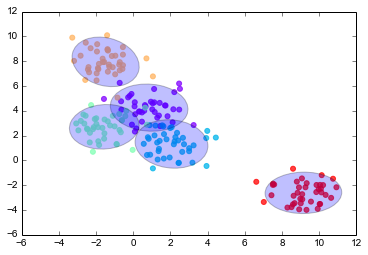

In [5]:
%matplotlib inline

X, labels = genBlobs(centers=5)
mu, sigma = mlParams(X,labels)
plotGaussian(X,labels,mu,sigma)

Call the `testClassifier` and `plotBoundary` functions for this part.

In [6]:
testClassifier(BayesClassifier(), dataset='iris', split=0.7)

Trial: 0 Accuracy 97.8
Trial: 10 Accuracy 100
Trial: 20 Accuracy 93.3
Trial: 30 Accuracy 95.6
Trial: 40 Accuracy 97.8
Trial: 50 Accuracy 100
Trial: 60 Accuracy 97.8
Trial: 70 Accuracy 95.6
Trial: 80 Accuracy 97.8
Trial: 90 Accuracy 95.6
Final mean classification accuracy  96.7 with standard deviation 1.87


In [7]:
testClassifier(BayesClassifier(), dataset='vowel', split=0.7)

Trial: 0 Accuracy 90.9
Trial: 10 Accuracy 89
Trial: 20 Accuracy 92.9
Trial: 30 Accuracy 91.6
Trial: 40 Accuracy 91.6
Trial: 50 Accuracy 89.6
Trial: 60 Accuracy 90.9
Trial: 70 Accuracy 89
Trial: 80 Accuracy 85.7
Trial: 90 Accuracy 89
Final mean classification accuracy  90.6 with standard deviation 2.26


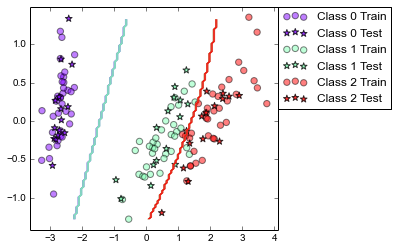

In [8]:
%matplotlib inline
plotBoundary(BayesClassifier(), dataset='iris',split=0.7)


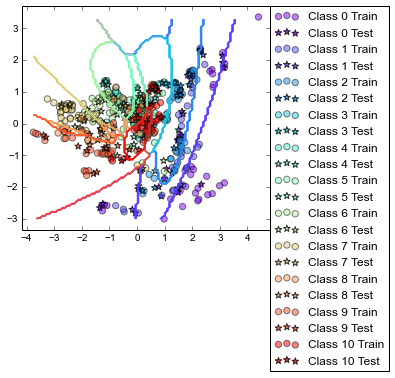

In [9]:
plotBoundary(BayesClassifier(), dataset='vowel',split=0.7)

Answer the following questions:

1) When can a feature independence assumption be reasonable and when not?

If we have multiclass 

2) How does the decision boundary look for the Iris dataset? How could one improve the classification results for this scenario by changing classifier or, alternatively, manipulating the data?



## Boosting functions to implement

The lab descriptions state what each function should do.

In [ ]:
# in: base_classifier - a classifier of the type that we will boost, e.g. BayesClassifier
#                   X - N x d matrix of N data points
#              labels - N vector of class labels
#                   T - number of boosting iterations
# out:    classifiers - (maximum) length T Python list of trained classifiers
#              alphas - (maximum) length T Python list of vote weights
def trainBoost(base_classifier, X, labels, T=10):
    # these will come in handy later on
    Npts,Ndims = np.shape(X)

    classifiers = [] # append new classifiers to this list
    alphas = [] # append the vote weight of the classifiers to this list

    # The weights for the first iteration
    wCur = np.ones((Npts,1))/float(Npts)

    for i_iter in range(0, T):
        # a new classifier can be trained like this, given the current weights
        classifiers.append(base_classifier.trainClassifier(X, labels, wCur))

        # do classification for each point
        vote = classifiers[-1].classify(X)

        # TODO: Fill in the rest, construct the alphas etc.
        # ==========================
        
        # alphas.append(alpha) # you will need to append the new alpha
        # ==========================
        
    return classifiers, alphas

# in:       X - N x d matrix of N data points
# classifiers - (maximum) length T Python list of trained classifiers as above
#      alphas - (maximum) length T Python list of vote weights
#    Nclasses - the number of different classes
# out:  yPred - N vector of class predictions for test points
def classifyBoost(X, classifiers, alphas, Nclasses):
    Npts = X.shape[0]
    Ncomps = len(classifiers)

    # if we only have one classifier, we may just classify directly
    if Ncomps == 1:
        return classifiers[0].classify(X)
    else:
        votes = np.zeros((Npts,Nclasses))

        # TODO: implement classificiation when we have trained several classifiers!
        # here we can do it by filling in the votes vector with weighted votes
        # ==========================
        
        # ==========================

        # one way to compute yPred after accumulating the votes
        return np.argmax(votes,axis=1)

The implemented functions can now be summarized another classifer, the `BoostClassifier` class. This class enables boosting different types of classifiers by initializing it with the `base_classifier` argument. No need to add anything here.

In [ ]:
# NOTE: no need to touch this
class BoostClassifier(object):
    def __init__(self, base_classifier, T=10):
        self.base_classifier = base_classifier
        self.T = T
        self.trained = False

    def trainClassifier(self, X, labels):
        rtn = BoostClassifier(self.base_classifier, self.T)
        rtn.nbr_classes = np.size(np.unique(labels))
        rtn.classifiers, rtn.alphas = trainBoost(self.base_classifier, X, labels, self.T)
        rtn.trained = True
        return rtn

    def classify(self, X):
        return classifyBoost(X, self.classifiers, self.alphas, self.nbr_classes)

## Run some experiments

Call the `testClassifier` and `plotBoundary` functions for this part.

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='iris',split=0.7)

In [ ]:
testClassifier(BoostClassifier(BayesClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(BayesClassifier()), dataset='iris',split=0.7)

Now repeat the steps with a decision tree classifier.

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='iris', split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

In [ ]:
testClassifier(DecisionTreeClassifier(), dataset='vowel',split=0.7)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='vowel',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(DecisionTreeClassifier(), dataset='iris',split=0.7)

In [ ]:
%matplotlib inline
plotBoundary(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='iris',split=0.7)

## Bonus: Visualize faces classified using boosted decision trees

Note that this part of the assignment is completely voluntary! First, let's check how a boosted decision tree classifier performs on the olivetti data. Note that we need to reduce the dimension a bit using PCA, as the original dimension of the image vectors is `64 x 64 = 4096` elements.

In [ ]:
testClassifier(BayesClassifier(), dataset='olivetti',split=0.7, dim=20)

In [ ]:
testClassifier(BoostClassifier(DecisionTreeClassifier(), T=10), dataset='olivetti',split=0.7, dim=20)

You should get an accuracy around 70%. If you wish, you can compare this with using pure decision trees or a boosted bayes classifier. Not too bad, now let's try and classify a face as belonging to one of 40 persons!

In [ ]:
%matplotlib inline
X,y,pcadim = fetchDataset('olivetti') # fetch the olivetti data
xTr,yTr,xTe,yTe,trIdx,teIdx = trteSplitEven(X,y,0.7) # split into training and testing
pca = decomposition.PCA(n_components=20) # use PCA to reduce the dimension to 20
pca.fit(xTr) # use training data to fit the transform
xTrpca = pca.transform(xTr) # apply on training data
xTepca = pca.transform(xTe) # apply on test data
# use our pre-defined decision tree classifier together with the implemented
# boosting to classify data points in the training data
classifier = BoostClassifier(DecisionTreeClassifier(), T=10).trainClassifier(xTrpca, yTr)
yPr = classifier.classify(xTepca)
# choose a test point to visualize
testind = random.randint(0, xTe.shape[0]-1)
# visualize the test point together with the training points used to train
# the class that the test point was classified to belong to
visualizeOlivettiVectors(xTr[yTr == yPr[testind],:], xTe[testind,:])